In [1]:
%matplotlib inline
import os
from scipy import misc
from scipy import ndimage
import numpy as np
import Plotting as plt
import matplotlib.pyplot as mplt
import copy



def fit_line(data):
    assert data.shape[1] == 2, "Data is not an nx2 array."
    x=data[:,0]
    y=data[:,1]
    A = np.vstack([x, np.ones(len(y))]).T
    return np.linalg.lstsq(A, y)[0]


def nearest(array, value):
    if isinstance(array, (list, tuple)):
        array = np.asarray(array)
        
    if isinstance(value, (list, tuple)):
        pos = (np.sum((array - value)**2, axis=1)**(1/2)).argmin()
        if len(array.shape) == 3:
            return np.unravel_index(pos, array.shape)
        else: 
            return pos
    else:
        pos = (np.abs(array - value)).argmin()
        if len(array.shape) == 2:
            return np.unravel_index(pos, array.shape)
        else: 
            return pos

class segment_img(object):
    def __init__(self, img_path, threshold, crop=None, closing=10, opening=10):    
        img = misc.imread(img_path)
        
        if crop is not None:
            img = img[crop[0][0]:crop[0][1], crop[1][0]:crop[1][1]]
        
        b_img = np.mean(img, axis=2) < threshold
        b_img = ndimage.binary_closing(b_img, iterations=closing)
        b_img = ndimage.binary_opening(b_img, iterations=opening)
        label_im, nb_labels = ndimage.label(b_img)
        
        center = np.asarray(ndimage.center_of_mass(b_img, label_im, range(1, nb_labels + 1)))
        size = np.asarray(ndimage.sum(b_img, label_im, range(1, nb_labels + 1)))
        
        self.image = img
        self.binary = b_img
        self.labels = label_im
        self.centers = center
        self.sizes = size

        
def euclidean_dist(point1, point2):
    return np.sum((np.asarray(point1) - np.asarray(point2))**2)**(1/2)


def img_len(img_path, threshold, marker_sizes, crop=None, closing=10, opening=10):
    
    data = segment_img(img_path, threshold, crop=crop, closing=closing, opening=opening)

    idx1 = nearest(data.sizes, marker_sizes[0])
    point1 = data.centers[idx1]

    idx2 = nearest(np.delete(data.sizes, idx1), marker_sizes[1])
    point2 = np.delete(data.centers, idx1, axis=0)[idx2]
        
    return euclidean_dist(point1, point2)

    
def img_load(data, images):
    numbs = np.asarray([int((file[:-4].split('_'))[-1]) for file in images])
    return np.take(data[:, 2], np.asarray([np.where(data[:, 0] == numb)[0] for numb in numbs]).flatten())


def get_SS(strain, stress):
    return np.dstack((np.asarray(strain), np.asarray(stress)))[0]


# Extract SS

AL 6061 T6  
UTS = 328.5 MPa  
Yield = 279 MPa  

In [2]:
rail_data = np.loadtxt('Data/Rail_Frame.dat', skiprows=3)

rail_imgs=[]
path = 'Data/Rail_Frame_Imgs/'
for file in sorted(os.listdir(path)):
    if file.endswith('.tif'):
        rail_imgs.append(path + file)       

cal = 30/996.057 #mm/pixel
area = (0.79*3.03)

[ 100443.     661.     586.   36088.]


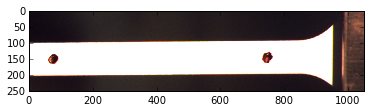

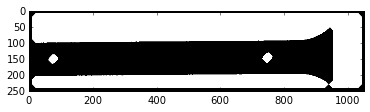

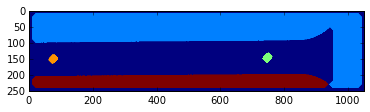

In [7]:
test = segment_img(rail_imgs[0], 100, crop=((550, 800), (150, 1200)), closing=10, opening=10)
print(test.sizes)

mplt.imshow(test.image, cmap = mplt.cm.Greys_r)
mplt.axes().set_aspect('equal')
mplt.show()
mplt.imshow(test.binary, cmap = mplt.cm.Greys_r)
mplt.axes().set_aspect('equal')
mplt.show()
mplt.imshow(test.labels)
mplt.axes().set_aspect('equal')
mplt.show()

In [3]:
threshold = 100
sizes = [(661, 586), (678, 557)]
crop = ((550, 800), (150, 1200))

img_lens = [img_len(frame, threshold, sizes[0], crop)*cal for frame in rail_imgs[:-1]]
img_SS = get_SS(((img_lens - img_lens[0])/img_lens[0])*100, img_load(rail_data, rail_imgs[:-1])/area)

In [4]:
rail_SS = rail_data[:, 1:]/[250, area]

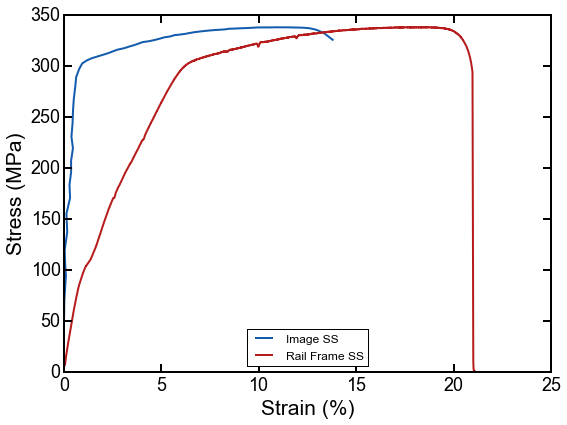

In [5]:
plt.line_plot((img_SS, rail_SS),
               xlabel = 'Strain (%)', ylabel = 'Stress (MPa)',
              colors=plt.get_COLORS(['blue', 'red']),
             linestyles=('-',),
              add_legend=('Image SS', 'Rail Frame SS')
              )